Part a : Ordinary Least Square (OLS) for the Runge function

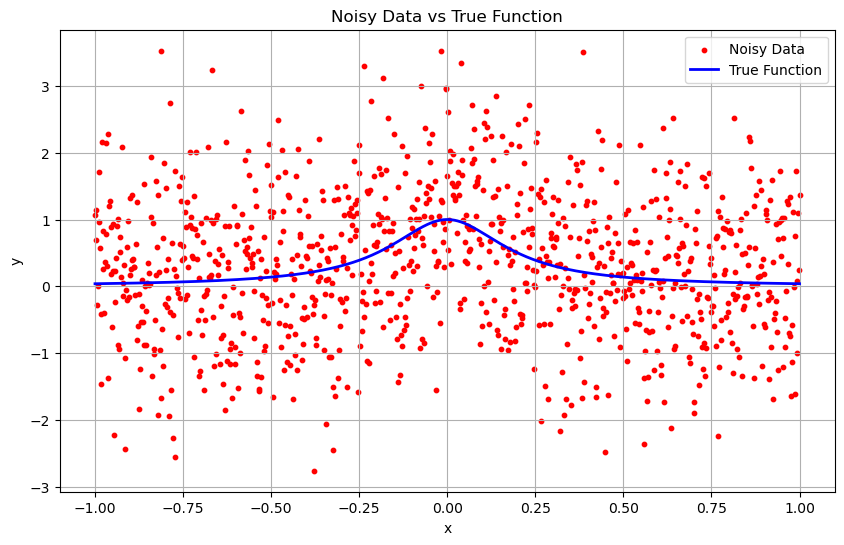

In [5]:
import numpy as np
import matplotlib.pyplot as plt

n= 1000
x = np.linspace(-1, 1, n)
y = 1/(1+25*x**2)
y_noisy = y + np.random.normal(0, 1, n)

plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy, color='red', label='Noisy Data', s=10)
plt.plot(x, y, color='blue', label='True Function', linewidth=2)
plt.title('Noisy Data vs True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()


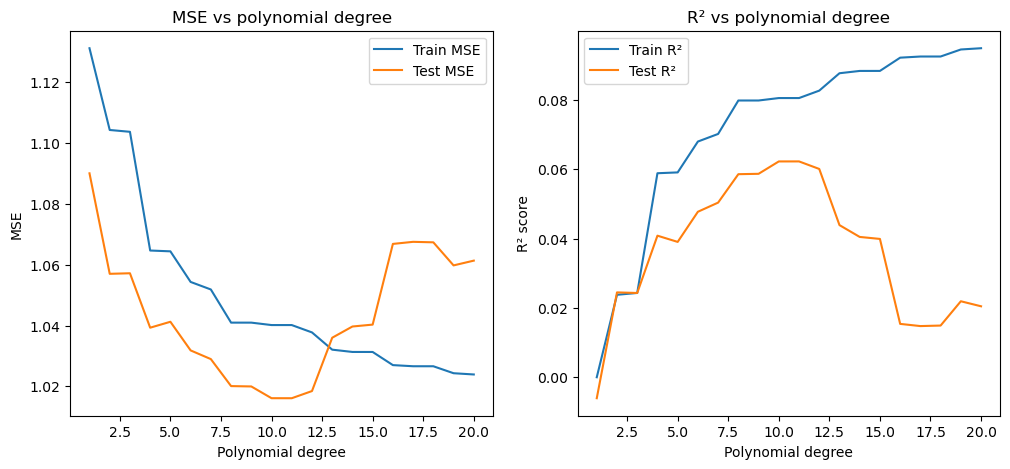

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def runge(x):
    return 1 / (1 + 25 * x**2)


def design_matrix(x, degree):
    return np.vstack([x**i for i in range(degree+1)]).T

def ols_fit(X, y):
    return np.linalg.pinv(X) @ y


def ols_predict(x, beta):
    X = design_matrix(x, len(beta)-1)
    return X @ beta


def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def r2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)



x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=0.2, random_state=42)


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1,1)).flatten()
x_test_scaled = scaler.transform(x_test.reshape(-1,1)).flatten()

degrees = range(1, 21)
mse_train, mse_test = [], []
r2_train, r2_test = [], []

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test = design_matrix(x_test_scaled, d)
    
    beta = ols_fit(X_train, y_train)
    
    y_train_hat = X_train @ beta
    y_test_hat = X_test @ beta
    
    mse_train.append(mse(y_train, y_train_hat))
    mse_test.append(mse(y_test, y_test_hat))
    
    r2_train.append(r2(y_train, y_train_hat))
    r2_test.append(r2(y_test, y_test_hat))


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(degrees, mse_train, label="Train MSE")
plt.plot(degrees, mse_test, label="Test MSE")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE vs polynomial degree")

plt.subplot(1,2,2)
plt.plot(degrees, r2_train, label="Train R²")
plt.plot(degrees, r2_test, label="Test R²")
plt.xlabel("Polynomial degree")
plt.ylabel("R² score")
plt.legend()
plt.title("R² vs polynomial degree")

plt.show()

Part B: 

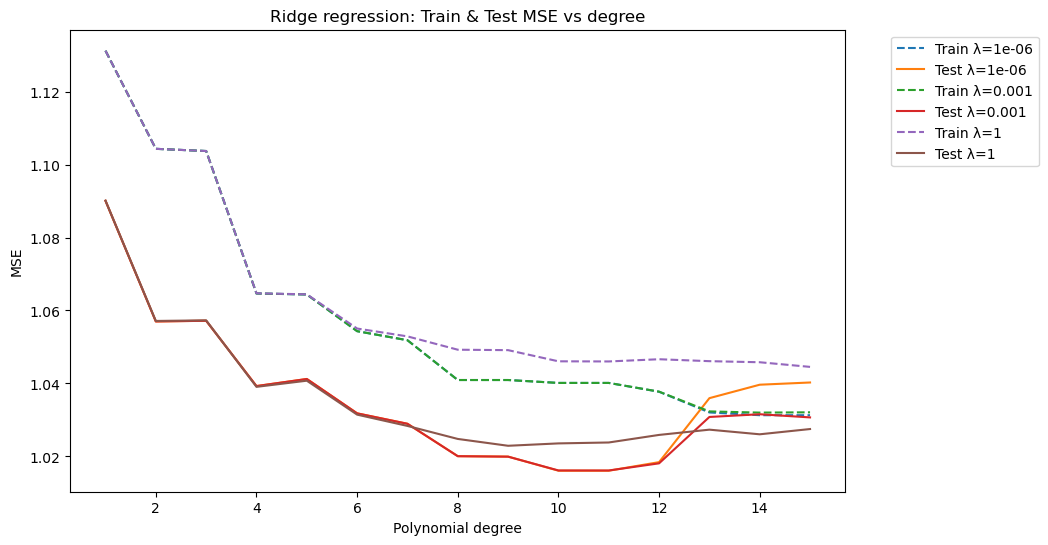

In [38]:
def ridge_fit(X, y, lam):
    n, p = X.shape
    I = np.eye(p)
    return np.linalg.pinv(X.T @ X + lam * I) @ (X.T @ y)

lambdas = [1e-6, 1e-3, 1]
degrees = range(1, 16)

mse_train_ridge = {lam: [] for lam in lambdas}
mse_test_ridge  = {lam: [] for lam in lambdas}

for lam in lambdas:
    for d in degrees:
        X_train = design_matrix(x_train_scaled, d)
        X_test = design_matrix(x_test_scaled, d)

        beta = ridge_fit(X_train, y_train, lam)

        y_train_hat = X_train @ beta
        y_test_hat = X_test @ beta
        
        mse_train_ridge[lam].append(mse(X_train, y_train, beta))
        mse_test_ridge[lam].append(mse(X_test, y_test, beta))



plt.figure(figsize=(10,6))
for lam in lambdas:
    plt.plot(degrees, mse_train_ridge[lam], "--", label=f"Train λ={lam}")
    plt.plot(degrees, mse_test_ridge[lam], "-",  label=f"Test λ={lam}")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Ridge regression: Train & Test MSE vs degree")
plt.legend(handles=plt.gca().get_legend_handles_labels()[0], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



Part C:

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

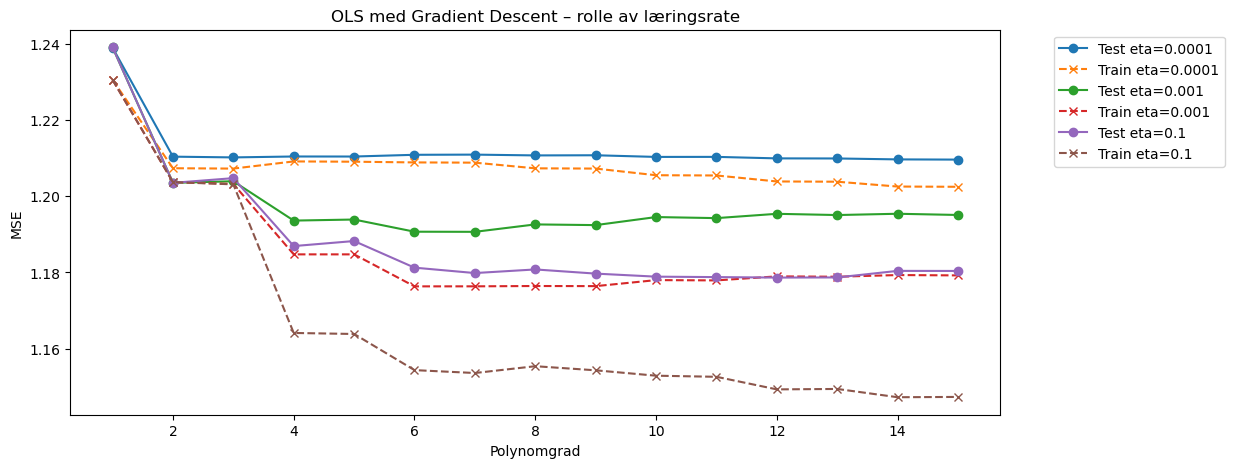

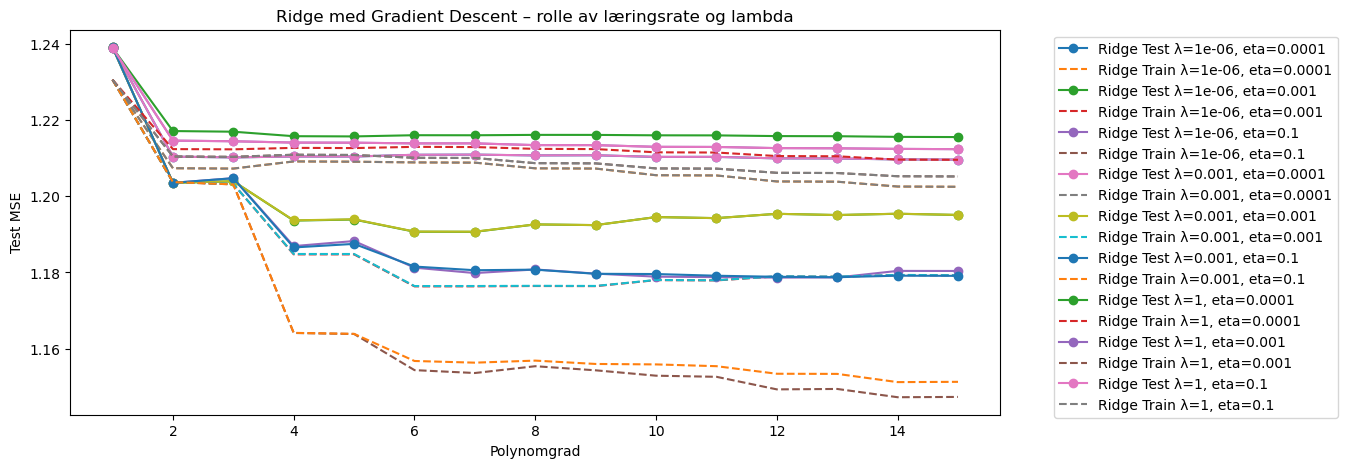

In [48]:
def gd_ols(X, y, eta=0.1, num_iters=100):
    n, d = X.shape
    theta = np.zeros(d)
    for _ in range(num_iters):
        grad = (2.0/n) * (X.T @ (X @ theta - y))
        theta -= eta * grad
    return theta

def gd_ridge(X, y, lam=0.1, eta=0.1, num_iters=100):
    n, d = X.shape
    theta = np.zeros(d)
    for _ in range(num_iters):
        grad = (2.0/n) * (X.T @ (X @ theta - y)) + 2*lam*theta
        theta -= eta * grad
    return theta

def mse(X, y, theta):
    r = y - X @ theta
    return (r @ r) / len(y)


etas   = [1e-4, 1e-3, 0.1]
iters  = 5000
max_degree = 15

scalerX = StandardScaler()

plt.figure(figsize=(12,5))

for eta in etas:
    train_mse, test_mse = [], []
    for deg in range(1, max_degree+1):
        poly = PolynomialFeatures(degree=deg, include_bias=True)

        Xtr = scalerX.fit_transform(poly.fit_transform(x_train_scaled.reshape(-1,1)))
        Xte = scalerX.transform(poly.transform(x_test_scaled.reshape(-1,1)))
        
        theta = gd_ols(Xtr, y_train, eta=eta, num_iters=iters)
        
        train_mse.append(mse(Xtr, y_train, theta))
        test_mse.append(mse(Xte, y_test, theta))

        if np.any(np.isnan(theta)) or np.any(np.isinf(theta)):
            print(f"Divergerte for eta={eta}, grad={deg}")
            break
    
    plt.plot(range(1, max_degree+1), test_mse, marker="o", label=f"Test eta={eta}")
    plt.plot(range(1, max_degree+1), train_mse, marker="x", linestyle="--", label=f"Train eta={eta}") 

plt.xlabel("Polynomgrad")
plt.ylabel("MSE")
plt.title("OLS med Gradient Descent – rolle av læringsrate")
plt.legend(handles=plt.gca().get_legend_handles_labels()[0], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


plt.figure(figsize=(12,5))
for lam in lambdas:
    for eta in etas:
        train_mse, test_mse = [], []
        for deg in range(1, max_degree+1):
            poly = PolynomialFeatures(degree=deg, include_bias=True)
            
            Xtr = scalerX.fit_transform(poly.fit_transform(x_train_scaled.reshape(-1,1)))
            Xte = scalerX.transform(poly.transform(x_test_scaled.reshape(-1,1)))

            theta = gd_ridge(Xtr, y_train, lam=lam, eta=eta, num_iters=iters)

            train_mse.append(mse(Xtr, y_train, theta))
            test_mse.append(mse(Xte, y_test, theta))

        plt.plot(range(1, max_degree+1), test_mse, marker="o", 
                 label=f"Ridge Test λ={lam}, eta={eta}")
        plt.plot(range(1, max_degree+1), train_mse, "--", 
                 label=f"Ridge Train λ={lam}, eta={eta}")
  

plt.xlabel("Polynomgrad")
plt.ylabel("Test MSE")
plt.title("Ridge med Gradient Descent – rolle av læringsrate og lambda")
plt.legend(handles=plt.gca().get_legend_handles_labels()[0], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Part d: 

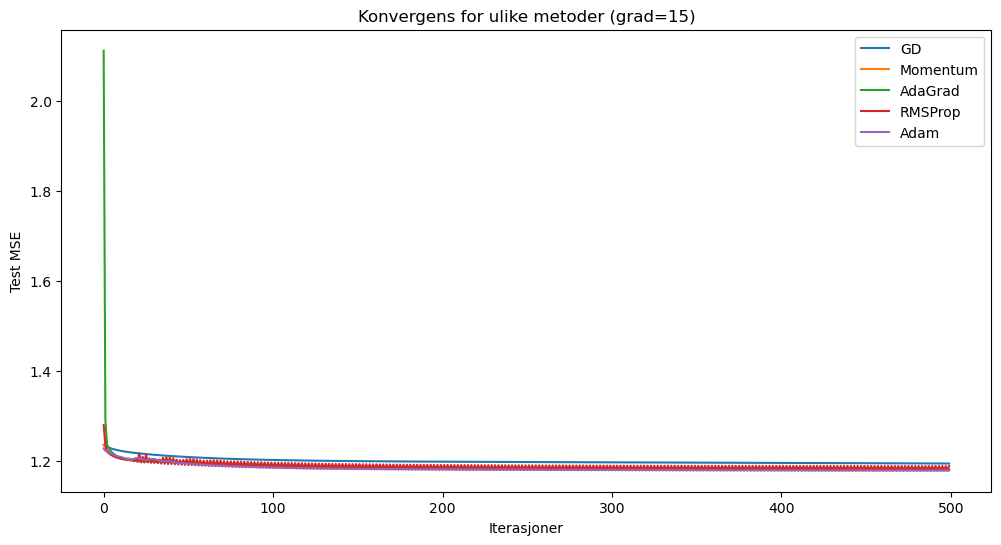

In [49]:
def gd(X, y, eta=0.01, num_iters=1000):
    n, d = X.shape
    theta = np.zeros(d)
    mse_hist = []
    for _ in range(num_iters):
        grad = (2.0/n) * (X.T @ (X @ theta - y))
        theta -= eta * grad
        mse_hist.append(mse(Xte, y_test, theta))
    return theta, mse_hist

def gd_momentum(X, y, eta=0.01, num_iters=1000, gamma=0.9):
    n, d = X.shape
    theta = np.zeros(d)
    v = np.zeros(d)
    mse_hist = []
    for _ in range(num_iters):
        grad = (2.0/n) * (X.T @ (X @ theta - y))
        v = gamma * v + eta * grad
        theta -= v
        mse_hist.append(mse(Xte, y_test, theta))
    return theta, mse_hist

def gd_adagrad(X, y, eta=0.1, num_iters=1000, eps=1e-8):
    n, d = X.shape
    theta = np.zeros(d)
    G = np.zeros(d)
    mse_hist = []
    for _ in range(num_iters):
        grad = (2.0/n) * (X.T @ (X @ theta - y))
        G += grad**2
        theta -= (eta / (np.sqrt(G) + eps)) * grad
        mse_hist.append(mse(Xte, y_test, theta))
    return theta, mse_hist

def gd_rmsprop(X, y, eta=0.01, num_iters=1000, beta=0.9, eps=1e-8):
    n, d = X.shape
    theta = np.zeros(d)
    Eg = np.zeros(d)
    mse_hist = []
    for _ in range(num_iters):
        grad = (2.0/n) * (X.T @ (X @ theta - y))
        Eg = beta * Eg + (1-beta) * grad**2
        theta -= (eta / (np.sqrt(Eg) + eps)) * grad
        mse_hist.append(mse(Xte, y_test, theta))
    return theta, mse_hist

def gd_adam(X, y, eta=0.01, num_iters=1000, beta1=0.9, beta2=0.999, eps=1e-8):
    n, d = X.shape
    theta = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    mse_hist = []
    for t in range(1, num_iters+1):
        grad = (2.0/n) * (X.T @ (X @ theta - y))
        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*(grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        theta -= eta * m_hat / (np.sqrt(v_hat) + eps)
        mse_hist.append(mse(Xte, y_test, theta))
    return theta, mse_hist

# --- Kjør eksperiment ---
methods = {
    "GD": lambda: gd(Xtr, y_train, eta=0.01, num_iters=500),
    "Momentum": lambda: gd_momentum(Xtr, y_train, eta=0.01, num_iters=500),
    "AdaGrad": lambda: gd_adagrad(Xtr, y_train, eta=0.1, num_iters=500),
    "RMSProp": lambda: gd_rmsprop(Xtr, y_train, eta=0.01, num_iters=500),
    "Adam": lambda: gd_adam(Xtr, y_train, eta=0.01, num_iters=500),
}

plt.figure(figsize=(12,6))
for name, f in methods.items():
    _, mse_hist = f()
    plt.plot(mse_hist, label=name)

plt.xlabel("Iterasjoner")
plt.ylabel("Test MSE")
plt.title(f"Konvergens for ulike metoder (grad={deg})")
plt.legend()
plt.show()